In [242]:
FILE_NAME = 'magazine_dataset.csv'

import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from sklearn.preprocessing import MinMaxScaler

tf.__version__

'2.0.0'

In [243]:
def plot_series(time, series, lab, form='-', start=0, end=None):
    plt.plot(time[start:end], series[start:end], form, label=lab)
    plt.xlabel("Minuto")
    plt.ylabel("Preço")
    plt.grid(True)
    
def split_dataset(dataset):
    size = dataset.shape[0]
    train_size = size * 80 // 100
    test_size = (size - train_size) // 2
    
    return dataset[0:train_size, :], dataset[train_size:(train_size + test_size), :], dataset[(train_size + test_size):size, :]

def windowed_dataset(series_x, series_y, batch_size, shuffle_buffer):
    ds = tf.data.Dataset.from_tensor_slices((series_x, series_y))
    ds = ds.shuffle(shuffle_buffer)

    return ds.batch(batch_size).prefetch(1).repeat()

In [244]:
data = pd.read_csv(FILE_NAME, sep=',')
data = data[['open', 'high', 'low', 'close', 'dollar_close', 'volume', 'sentiment_polarity', 'close']]
data.columns.values[7] = "y"
data.head()

,open,high,low,close,dollar_close,volume,sentiment_polarity,y
0,33.0013,33.0316,32.7213,32.8513,4.1007,0,0.06801,32.8513
1,32.8810,33.1225,32.8522,33.0411,4.0994,301337,0.06801,33.0411
2,33.0200,33.3100,33.0200,33.1300,4.0979,177100,0.06801,33.1300
3,33.1506,33.1761,32.9759,33.0006,4.0971,179428,0.06801,33.0006
4,33.0012,33.1010,32.9008,32.9112,4.0974,204443,0.06801,32.9112


In [245]:
dataset = data['y']
dataset.loc[dataset.shape[0]]= 0.0
dataset = dataset.iloc[1:]
data.iloc[:, -1] = dataset.values
dataset = data[:-1]

dataset_to_numpy = dataset.values
dataset.head()

,open,high,low,close,dollar_close,volume,sentiment_polarity,y
0,33.0013,33.0316,32.7213,32.8513,4.1007,0,0.06801,33.0411
1,32.8810,33.1225,32.8522,33.0411,4.0994,301337,0.06801,33.1300
2,33.0200,33.3100,33.0200,33.1300,4.0979,177100,0.06801,33.0006
3,33.1506,33.1761,32.9759,33.0006,4.0971,179428,0.06801,32.9112
4,33.0012,33.1010,32.9008,32.9112,4.0974,204443,0.06801,32.8800


In [246]:
train_dataset, cross_validation_dataset, dev_dataset = split_dataset(dataset_to_numpy)

print("Dataset shape: {:s}".format(str(dataset_to_numpy.shape)))
print("Train dataset shape: {:s}".format(str(train_dataset.shape)))
print("Cross validation dataset shape: {:s}".format(str(cross_validation_dataset.shape)))
print("Dev dataset shape: {:s}".format(str(dev_dataset.shape)))

Dataset shape: (11796, 8)
Train dataset shape: (9436, 8)
Cross validation dataset shape: (1180, 8)
Dev dataset shape: (1180, 8)


# Stock prices graph

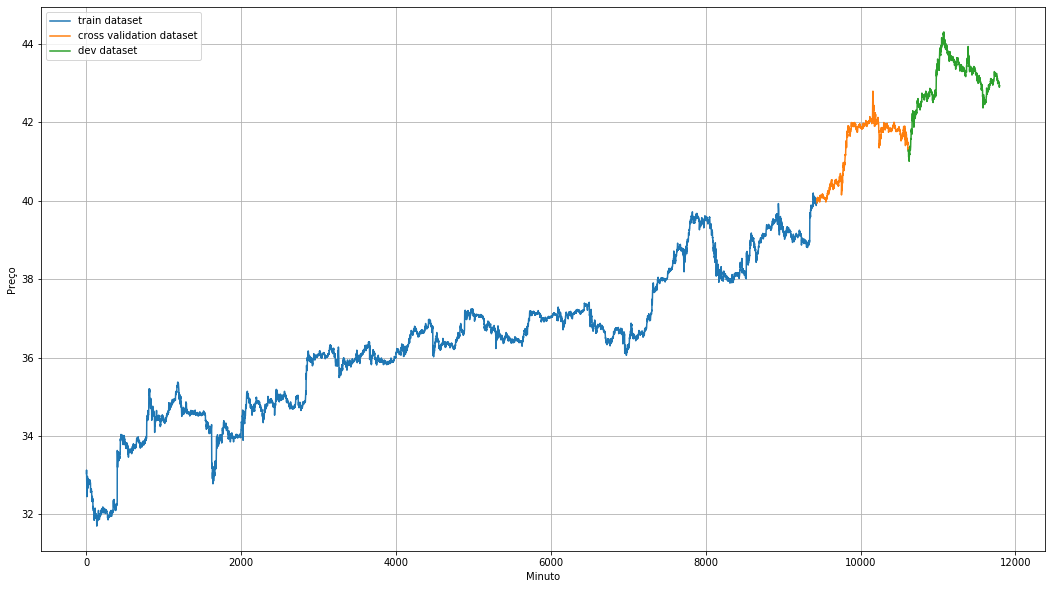

In [247]:
plt.figure(figsize=(18, 10))
plot_series(np.arange(train_dataset.shape[0]), train_dataset[:, -1], "train dataset")
plot_series(np.arange(train_dataset.shape[0], (cross_validation_dataset.shape[0] + train_dataset.shape[0])), cross_validation_dataset[:, -1], "cross validation dataset")
plot_series(np.arange((cross_validation_dataset.shape[0] + train_dataset.shape[0]), (cross_validation_dataset.shape[0]+ train_dataset.shape[0] + dev_dataset.shape[0])), dev_dataset[:, -1], "dev dataset")
plt.legend(loc='upper left')

# Data normalization

In [257]:
scaler = MinMaxScaler()
scaler = scaler.fit(train_dataset[:, 0:-1])
train_dataset_normalized = scaler.transform(train_dataset[:, 0:-1])
cross_validation_dataset_normalized = scaler.transform(cross_validation_dataset[:, 0:-1])
dev_dataset_normalized = scaler.transform(dev_dataset[:, 0:-1])

[1.17388803e-01 1.18879207e-01 1.18069330e-01 1.17635987e-01
 6.07533414e+00 1.18066542e-07 4.01140208e+00]


In [253]:
train_set = windowed_dataset(train_dataset_normalized[:, :, np.newaxis], train_dataset[:, -1], 128, 1000)
cross_validation_set = windowed_dataset(cross_validation_dataset_normalized[:, :, np.newaxis], cross_validation_dataset[:, -1], 128, 1000)
dev_set = windowed_dataset(dev_dataset_normalized[:, :, np.newaxis], dev_dataset[:, -1], 128, 1000)

# Define the model

In [287]:
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=5, strides=1, padding="causal", activation="relu", input_shape=[None, 1]),
#     tf.keras.layers.MaxPooling1D(strides=1, padding="same"),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
#     tf.keras.layers.Lambda(lambda x: x * 100)
])

model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9), metrics=['mae'])
model.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_27 (Conv1D)           (None, None, 64)          384       
_________________________________________________________________
lstm_54 (LSTM)               (None, None, 128)         98816     
_________________________________________________________________
lstm_55 (LSTM)               (None, None, 64)          49408     
_________________________________________________________________
dense_81 (Dense)             (None, None, 32)          2080      
_________________________________________________________________
dense_82 (Dense)             (None, None, 10)          330       
_________________________________________________________________
dense_83 (Dense)             (None, None, 1)           11        
Total params: 151,029
Trainable params: 151,029
Non-trainable params: 0
_______________________________________________

In [288]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
history = model.fit(train_set, epochs=200, steps_per_epoch=100, callbacks=[lr_schedule])

Train for 100 steps
Epoch 1/200
100/100 [==============================] - 4s 39ms/step - loss: 1289.0138 - mae: 35.8473
Epoch 2/200
100/100 [==============================] - 1s 10ms/step - loss: 1325.2992 - mae: 36.3622
Epoch 3/200
100/100 [==============================] - 1s 10ms/step - loss: 1347.3615 - mae: 36.6434
Epoch 4/200
100/100 [==============================] - 1s 10ms/step - loss: 1294.8526 - mae: 35.9319
Epoch 5/200
100/100 [==============================] - 1s 10ms/step - loss: 1329.6402 - mae: 36.4208
Epoch 6/200
100/100 [==============================] - 1s 10ms/step - loss: 1335.9630 - mae: 36.4825
Epoch 7/200
100/100 [==============================] - 1s 10ms/step - loss: 1300.7048 - mae: 36.0161
Epoch 8/200
100/100 [==============================] - 1s 10ms/step - loss: 1334.1954 - mae: 36.4826
Epoch 9/200
100/100 [==============================] - 1s 10ms/step - loss: 1323.9900 - mae: 36.3173
Epoch 10/200
100/100 [==============================] - 1s 10ms/step - 

Epoch 82/200
100/100 [==============================] - 1s 10ms/step - loss: 1.4603 - mae: 0.8506
Epoch 83/200
100/100 [==============================] - 1s 10ms/step - loss: 2.1166 - mae: 1.0428
Epoch 84/200
100/100 [==============================] - 1s 10ms/step - loss: 1.5227 - mae: 0.8933
Epoch 85/200
100/100 [==============================] - 1s 10ms/step - loss: 1.3664 - mae: 0.8147
Epoch 86/200
100/100 [==============================] - 1s 10ms/step - loss: 1.8924 - mae: 0.9838
Epoch 87/200
100/100 [==============================] - 1s 10ms/step - loss: 1.3227 - mae: 0.8254
Epoch 88/200
100/100 [==============================] - 1s 10ms/step - loss: 1.2750 - mae: 0.7995
Epoch 89/200
100/100 [==============================] - 1s 10ms/step - loss: 1.8903 - mae: 0.9985
Epoch 90/200
100/100 [==============================] - 1s 10ms/step - loss: 1.1324 - mae: 0.7533
Epoch 91/200
100/100 [==============================] - 1s 10ms/step - loss: 1.0741 - mae: 0.7404
Epoch 92/200
100/100

100/100 [==============================] - 1s 11ms/step - loss: 8.5565 - mae: 2.0009
Epoch 165/200
100/100 [==============================] - 1s 11ms/step - loss: 8.4719 - mae: 1.9391
Epoch 166/200
100/100 [==============================] - 1s 11ms/step - loss: 45.7038 - mae: 4.7567
Epoch 167/200
100/100 [==============================] - 1s 11ms/step - loss: 850033754219704093408081016258560.0000 - mae: 6622997947351040.0000
Epoch 168/200
100/100 [==============================] - 1s 11ms/step - loss: nan - mae: nan                            
Epoch 169/200
100/100 [==============================] - 1s 10ms/step - loss: nan - mae: nan
Epoch 170/200
100/100 [==============================] - 1s 10ms/step - loss: nan - mae: nan
Epoch 171/200
100/100 [==============================] - 1s 10ms/step - loss: nan - mae: nan
Epoch 172/200
100/100 [==============================] - 1s 10ms/step - loss: nan - mae: nan
Epoch 173/200
100/100 [==============================] - 1s 10ms/step - loss:

[1e-08, 0.1, 0, 30]

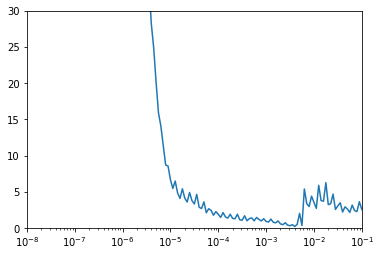

In [289]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-1, 0, 30])

In [294]:
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=5, strides=1, padding="causal", activation="relu", input_shape=[None, 1]),
    tf.keras.layers.MaxPooling1D(pool_size=2, strides=1, padding="valid"),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
#     tf.keras.layers.Lambda(lambda x: x * 100)
])

model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9), metrics=['mae'])
history = model.fit(train_set, epochs=25, steps_per_epoch=train_dataset.shape[0], validation_data=cross_validation_set, validation_steps=cross_validation_dataset.shape[0])

Train for 9436 steps, validate for 1180 steps
Epoch 1/25
9436/9436 [==============================] - 106s 11ms/step - loss: 37.2686 - mae: 2.1029 - val_loss: 5.1797 - val_mae: 1.5586
Epoch 2/25
9436/9436 [==============================] - 103s 11ms/step - loss: 0.6146 - mae: 0.5389 - val_loss: 2.6825 - val_mae: 1.1012
Epoch 3/25
9436/9436 [==============================] - 103s 11ms/step - loss: 0.4791 - mae: 0.4833 - val_loss: 3.1875 - val_mae: 1.3406
Epoch 4/25
9436/9436 [==============================] - 103s 11ms/step - loss: 0.3701 - mae: 0.4232 - val_loss: 1.5516 - val_mae: 0.7856
Epoch 5/25
9436/9436 [==============================] - 103s 11ms/step - loss: 0.2846 - mae: 0.3702 - val_loss: 2.1680 - val_mae: 1.1689
Epoch 6/25
9436/9436 [==============================] - 103s 11ms/step - loss: 0.2199 - mae: 0.3234 - val_loss: 1.0685 - val_mae: 0.6525
Epoch 7/25
9436/9436 [==============================] - 103s 11ms/step - loss: 0.1686 - mae: 0.2828 - val_loss: 1.4647 - val_mae: 0

In [295]:
model.save_weights('weights/model_weights.ckpt')

In [297]:
model.load_weights('weights/checkpoint')

OSError: Unable to open file (file signature not found)